In [1]:
# General python libraries and packages
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import os

# Processing chemical data
from rdkit import Chem
from rdkit.Chem import PandasTools, AllChem, Descriptors, Draw
from rdkit.Chem.Draw import MolsToGridImage, rdMolDraw2D, MolsMatrixToGridImage, IPythonConsole
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmilesFromSmiles

In [2]:
# Adjust how molecules are drawn! 
dpi = 300
canvas_size = 600  
d2d = Draw.MolDraw2DCairo(canvas_size, canvas_size) # Use a fixed canvas size
dopts = d2d.drawOptions()
dopts.fixedFontSize = 14
dopts.legendFontSize = 16
dopts.dummiesAreAttachments = True # Replace * by wavy lines
# dopts.addStereoAnnotation = True

# Print all the drawing options
# for attr in dir(dopts):
#      if not attr.startswith('_') and not callable(getattr(dopts, attr)):
#         try:
#             print(f"{attr}: {getattr(dopts, attr)}")
#         except Exception as e:
#             print(f"{attr}: <error reading value: {e}>")

# Set the drawOptions variable in the PandasTools module accordingly
PandasTools.drawOptions = dopts

# Also set how molecules are rendered within the Jupyter Notebook
IPythonConsole.drawOptions = dopts

# Import Dataset 
(File was generated in the 2_Data_Preparation_and_Overlap JupyterNotebook)

40290


,Dataset,ID,Ligand_Instance,PDB_ID,Standardized_SMILES,SMILES,Name,Pocket,ATP_Site,Peripheral,Num_H_Atoms_ProtBoundConf,Num_Resolved_Atoms,Num_Not_Resolved_Atoms,2D_Mol
0,CF,F001,001_B_2,NaN,[H]O[C@]1([H])C([H])([H])[C@@]([H])(C2=NC(C3=C...,O[C@H](C1)CN[C@@H]1c1nc(-c(cc2)ccc2F)n[o]1,"(3R,5S)‐5‐[3‐(4‐fluorophenyl)‐1,2,4‐oxadiazol‐...",X,1.0,1.0,13.0,18.0,0.0,

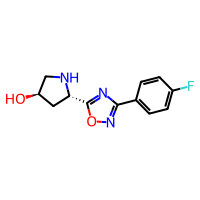

In [ ]:
df = pd.read_excel(os.path.join('Data', '_Molecule_Data_Combined.xlsx'))

# Draw molecules
PandasTools.AddMoleculeColumnToFrame(df, smilesCol="SMILES", molCol='2D_Mol')
PandasTools.RenderImagesInAllDataFrames(True)

print(len(df))
df.head(1)

# Generate Bemis-Murcko scaffolds variants

**Different Types of Bemis-Murcko scaffolds**: 

https://github.com/rdkit/rdkit/discussions/6844

In their paper, Bemis and Murcko present two types of "Molecular Frameworks". 
Molecules are deconstructed into side chains, rings and linkers. The framework is then the part of the molecule with side chains removed. This framework is called the "atomic framework" by them. This framework can be made generic by converting all bond types to single bond, and all atom types to carbon. This is what Bemis and Murcko call a "graph framework".

Using the language used by Bajorath and coworkers in this paper: https://pubs.acs.org/doi/10.1021/ci200179y
Atomic   frameworks as defined by Bemis and Murcko are referred to as BM scaffolds, and 
generic frameworks as defined by Bemis and Murcko are called CSKs (Cyclic SKeletons).

The variants True_BM, RDKit_BM and Bejorath_BM only differ by the fate of exo-bonded side-chains on the ring. 
The same applies for the RDKit_Generic and True_CSK scaffolds.

In [4]:
## Alternatively: 
## Adds column with SMILES of Murcko scaffolds to pandas DataFrame.
# PandasTools.AddMurckoToFrame(df, molCol='2D_Mol', MurckoCol='RDKit_BM', Generic=False)
# PandasTools.AddMurckoToFrame(df, molCol='2D_Mol', MurckoCol='RDKit_Generic', Generic=True)
## Aligns molecules in molCol to scaffolds in scaffoldCol
# PandasTools.AlignToScaffold(df, molCol='2D_Mol', scaffoldCol='RDKit_BM')

In [5]:
def get_scaffolds(df):
    # Define SMILES patterns for scaffold generation
    PATT=Chem.MolFromSmarts("[$([D1]=[*])]")
    REPL=Chem.MolFromSmarts("[*]")

    # Initialize scaffold DataFrame with columns ... 
    scaf_df = pd.DataFrame()
    scaf_df["Parent_Mol"]      = 0
    scaf_df["RDKit_BM"]        = 0
    scaf_df["True_BM"]         = 0
    scaf_df["Bajorath_BM"]     = 0
    scaf_df["RDKit_Generic"]   = 0
    scaf_df["True_CSK"]        = 0
    
    # Loop through molecules in input DataFrame 
    for i in range(len(df)):

        # Get molecule and remove stereochemistry 
        # Important for canonization of CSK!
        mol = df["2D_Mol"][i]
        Chem.RemoveStereochemistry(mol) 

        # Generate scaffold from molecule
        scaff = MurckoScaffold.GetScaffoldForMol(mol)

        # Store the parent molecule in the scaffold_df
        scaf_df.loc[i,"Parent_Mol"] = mol

        # Further Process the scaffold to get the different types of Bemis-Murcko scaffolds
        scaf_df["Bajorath_BM"][i]       = AllChem.DeleteSubstructs(scaff, PATT)
        scaf_df["RDKit_BM"][i]          = MurckoScaffold.GetScaffoldForMol(mol)
        scaf_df["True_BM"][i]           = AllChem.ReplaceSubstructs(scaff,PATT,REPL,replaceAll=True)[0]  
        scaf_df["RDKit_Generic"][i]     = MurckoScaffold.MakeScaffoldGeneric(scaff)
        use_csk = MurckoScaffold.MakeScaffoldGeneric(scaff)
        scaf_df["True_CSK"][i]          = MurckoScaffold.GetScaffoldForMol(use_csk)
    
    # Concatenate input DataFrame with scaffold DataFrame
    scaf_df = pd.concat([df, scaf_df], axis=1)

    # Drop the 2D_Mol column
    scaf_df = scaf_df.drop(columns=['2D_Mol'])

    return scaf_df      

,Dataset,ID,Ligand_Instance,PDB_ID,Standardized_SMILES,SMILES,Name,Pocket,ATP_Site,Peripheral,Num_H_Atoms_ProtBoundConf,Num_Resolved_Atoms,Num_Not_Resolved_Atoms,Parent_Mol,RDKit_BM,True_BM,Bajorath_BM,RDKit_Generic,True_CSK
0,CF,F001,001_B_2,NaN,[H]O[C@]1([H])C([H])([H])[C@@]([H])(C2=NC(C3=C...,O[C@H](C1)CN[C@@H]1c1nc(-c(cc2)ccc2F)n[o]1,"(3R,5S)‐5‐[3‐(4‐fluorophenyl)‐1,2,4‐oxadiazol‐...",X,1.0,1.0,13.0,18.0,0.0,,,,,,

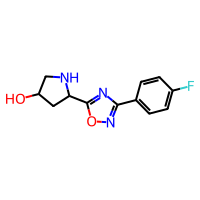
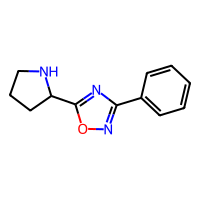
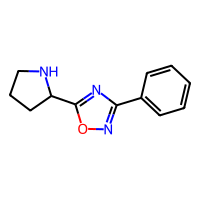
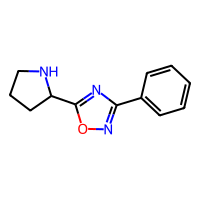
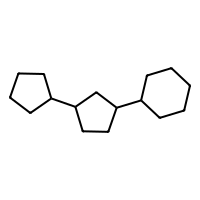
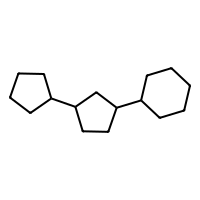

In [6]:
# Call function to generate scaffolds from molecules in the input dataframe
scaffold_df = get_scaffolds(df)

scaffold_df.head(1)

# Convert Bemis-Murcko Scaffold Variants to SMILES 
To enable further analysis

,Dataset,ID,Ligand_Instance,PDB_ID,Standardized_SMILES,SMILES,Name,Pocket,ATP_Site,Peripheral,...,RDKit_BM,True_BM,Bajorath_BM,RDKit_Generic,True_CSK,True_BM_SMILES,Bajorath_BM_SMILES,RDKit_BM_SMILES,RDKit_Generic_SMILES,True_CSK_SMILES
0,CF,F001,001_B_2,NaN,[H]O[C@]1([H])C([H])([H])[C@@]([H])(C2=NC(C3=C...,O[C@H](C1)CN[C@@H]1c1nc(-c(cc2)ccc2F)n[o]1,"(3R,5S)‐5‐[3‐(4‐fluorophenyl)‐1,2,4‐oxadiazol‐...",X,1.0,1.0,...,,,,,,c1ccc(-c2noc(C3CCCN3)n2)cc1,c1ccc(-c2noc(C3CCCN3)n2)cc1,c1ccc(-c2noc(C3CCCN3)n2)cc1,C1CCC(C2CCC(C3CCCC3)C2)CC1,C1CCC(C2CCC(C3CCCC3)C2)CC1

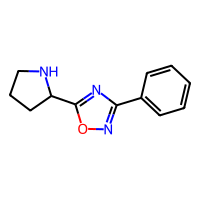
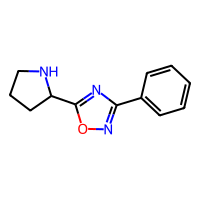
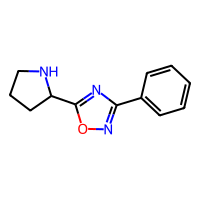
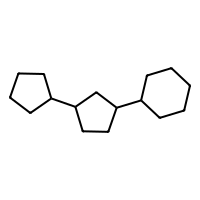
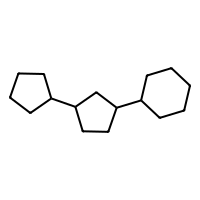

In [7]:
# Define the columns for the Bemis-Murcko Scaffold Variants and the ones with the corresponding SMILES/SMILES of these scaffolds
BM_scaffold_cols          = ["True_BM",        "Bajorath_BM",        "RDKit_BM",        "RDKit_Generic",        "True_CSK"]
BM_scaffold_SMILES_cols   = ["True_BM_SMILES", "Bajorath_BM_SMILES", "RDKit_BM_SMILES", "RDKit_Generic_SMILES", "True_CSK_SMILES"]

# Helper function (taken from https://www.rdkit.org/docs/Cookbook.html#neutralizing-molecules)
def neutralize_atoms(mol):
    pattern = Chem.MolFromSmarts("[+1!h0!$([*]~[-1,-2,-3,-4]),-1!$([*]~[+1,+2,+3,+4])]")
    at_matches = mol.GetSubstructMatches(pattern)
    at_matches_list = [y[0] for y in at_matches]
    if len(at_matches_list) > 0:
        for at_idx in at_matches_list:
            atom = mol.GetAtomWithIdx(at_idx)
            chg = atom.GetFormalCharge()
            hcount = atom.GetTotalNumHs()
            atom.SetFormalCharge(0)
            atom.SetNumExplicitHs(hcount - chg)
            atom.UpdatePropertyCache() 
    return mol

# Loop through both column lists defined before 
for BM_scaffold_col, BM_SMILES_col in zip(BM_scaffold_cols, BM_scaffold_SMILES_cols):
    # Neutralize the Bemis-Murcko Scaffold Variants
    scaffold_df[BM_scaffold_col] = scaffold_df[BM_scaffold_col].apply(lambda x: neutralize_atoms(x) if pd.notnull(x) else None)
    # Convert the Bemis-Murcko Scaffold Variants (molecule object) to SMILES
    scaffold_df[BM_SMILES_col] = scaffold_df[BM_scaffold_col].apply(lambda x: Chem.MolToSmiles(x, isomericSmiles=True))

# Drop column
scaffold_df = scaffold_df.drop(columns='Parent_Mol')

# Save to files
filepath = os.path.join('Analysis', 'Bemis_Murcko_Scaffolds')
save_df = scaffold_df.copy().drop(columns = BM_scaffold_cols) 
save_df.to_excel(os.path.join(filepath, 'Bemis_Murcko_Scaffolds.xlsx'), index=False)

scaffold_df.head(1)

,Dataset,ID,PDB_ID,RDKit_BM,True_BM,Bajorath_BM,RDKit_Generic,True_CSK,True_BM_SMILES,Bajorath_BM_SMILES,RDKit_BM_SMILES,RDKit_Generic_SMILES,True_CSK_SMILES
0,CF,F001,NaN,,,,,,c1ccc(-c2noc(C3CCCN3)n2)cc1,c1ccc(-c2noc(C3CCCN3)n2)cc1,c1ccc(-c2noc(C3CCCN3)n2)cc1,C1CCC(C2CCC(C3CCCC3)C2)CC1,C1CCC(C2CCC(C3CCCC3)C2)CC1

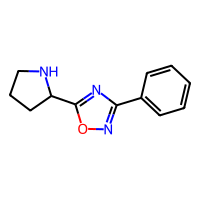
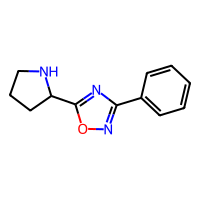
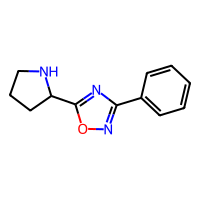
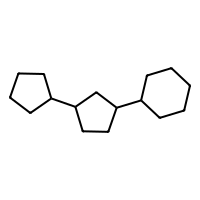
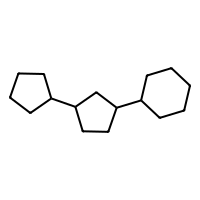

In [8]:
# Drop duplicates, based on identical dataset, molecule ID and BM_scaffold_SMILES_cols
cols = ['Dataset', 'ID'] + BM_scaffold_SMILES_cols
scaffold_df = scaffold_df.drop_duplicates(subset=cols).reset_index(drop=True)

# Also drop the columns specified
drop_cols = ['Ligand_Instance', 'Standardized_SMILES', 'SMILES', 'Name', 'Pocket', 'ATP_Site', 'Peripheral', 
             'Num_H_Atoms_ProtBoundConf', 'Num_Resolved_Atoms', 'Num_Not_Resolved_Atoms']
scaffold_df = scaffold_df.drop(columns=drop_cols)

scaffold_df.head(1)

In [9]:
# # Group the dataframe by 'Dataset' and 'ID' to identify molecules for which multiple tautomeric forms are present
# tautomers = scaffold_df.groupby(['Dataset', 'ID']).filter(lambda x: len(x) > 1)

# # Check if there are any and display them
# if not tautomers.empty:
#     tautomer_ids = tautomers['ID'].unique()
#     print(tautomer_ids)

# tautomers

# Analyze the Number of Different Scaffolds per Dataset for all Scaffold Variants

In [10]:
# Define a dictionary to store the unique count of each smiles column for each dataset
unique_smiles_count = {'CF': [], 'ChEMBL_Kinases': [], 'ChEMBL_PKA': [], 'PDB': [], 'OralDrugs' : [], 'PKIs' : []}

dataset_sizes = {}

# Loop through each dataset
for dataset in unique_smiles_count.keys():
    # Select the corresponding rows from the scaffold_df DataFrame, based on the Dataset column value
    scaff_df = scaffold_df.loc[scaffold_df['Dataset'] == dataset]

    # Determine the dataset size
    dataset_sizes[dataset] = scaff_df['ID'].nunique()  

    # Use list comprehension to calculate how many scaffold SMILES are unique for every column/different variants
    unique_counts = [scaff_df[col].nunique() for col in BM_scaffold_SMILES_cols]
    
    # Store the count in the dict
    unique_smiles_count[dataset] = dict(zip(BM_scaffold_SMILES_cols, unique_counts))

# Create a new DataFrame to store the dataset sizes
dataset_sizes_df = pd.DataFrame(list(dataset_sizes.items()), columns=['Dataset', 'Dataset_Size'])

# Create a new DataFrame to store the unique count of each smiles column for each dataset
unique_smiles_count_df = pd.DataFrame(unique_smiles_count).T
unique_smiles_count_df.reset_index(drop=False, inplace=True, names='Dataset')

# Merge the newly created dataframe with the one, that holds the dataset sizes 
unique_smiles_count_df = pd.merge(dataset_sizes_df, unique_smiles_count_df, on='Dataset', how='outer')
unique_smiles_count_df

,Dataset,Dataset_Size,True_BM_SMILES,Bajorath_BM_SMILES,RDKit_BM_SMILES,RDKit_Generic_SMILES,True_CSK_SMILES
0,CF,36,32,32,32,24,21
1,ChEMBL_Kinases,38721,16565,16320,16625,9059,7055
2,ChEMBL_PKA,71,54,54,54,45,44
3,PDB,160,91,91,91,71,67
4,OralDrugs,1064,727,706,729,566,475
5,PKIs,107,100,100,100,94,94


# Are there any scaffolds unique to the CF dataset?
## Compared to all reference datasets

In [11]:
# Create a subdataset for the CrystalsFirst data only
CF_scaffold_df = scaffold_df.loc[scaffold_df['Dataset'] == 'CF']
CF_scaffold_df = CF_scaffold_df.reset_index(drop=True)

In [12]:
# Create a subdataset for all molecules, except the CrystalsFirst ones
databases_scaffold_df = scaffold_df.loc[scaffold_df['Dataset'].isin(['ChEMBL_Kinases', 'ChEMBL_PKA', 'PDB', 'OralDrugs', 'PKIs'])]
databases_scaffold_df = databases_scaffold_df.reset_index(drop=True)

# Initialize a dictionary
unique_CF = {}

# Loop over the SMILES columns (of the Bemis-Murcko Variants)
for col in BM_scaffold_SMILES_cols:
    # To compare the subdataset of the CrystalsFirst molecule with the dataset for all other database 
    # Use the SMILES column of these subdatasets, convert to sets and find the difference, and convert result to list
    unique_CF[col] = list(set(CF_scaffold_df[col].to_list()) - set(databases_scaffold_df[col].to_list()))
    print(f"{len(unique_CF[col])} unique {col.replace('_SMILES', '')} scaffolds.")

32 unique True_BM scaffolds.
30 unique Bajorath_BM scaffolds.
32 unique RDKit_BM scaffolds.
8 unique RDKit_Generic scaffolds.
2 unique True_CSK scaffolds.


In [13]:
def identify_unique_scaffolds(df, reference_df, variant, parameters, filename=None):
    """
    Identify the unique Bemis-Murcko scaffolds in a dataframe compared to a reference dataframe.

    Parameters:
    df (pandas.DataFrame):           The dataframe to identify unique scaffolds from.
    reference_df (pandas.DataFrame): The reference dataframe to compare with.
    variant (str):                   The Bemis-Murcko variant to analyze.
    parameters (dict):               A dictionary of parameters for drawing the scaffolds grid.
    filename (str, optional):        The filename to save the grid image to.

    Returns:
    tuple:                           A tuple containing the dataframe of unique scaffolds and the grid image. 
    """
    # Add the suffix _SMILES to the Bemis-Murcko-Variant Name
    col = variant + '_SMILES'

    # Compare the sub-dataframes, based on the  SMILES column of the respective Bemis-Murcko-Variant
    # Result is a list of SMILES
    unique_scaffolds = list(set(df[col].to_list()) - set(reference_df[col].to_list()))

    print(f'{len(unique_scaffolds)} unique {variant} scaffolds.')

    if len(unique_scaffolds) != 0:

        # Show the rows of the df, for which the scaffold is unique
        unique_df = df[df[col].isin(unique_scaffolds)] 
        unique_df = unique_df.sort_values(by='ID')

        # Initialize default legend
        default_legend = [] 

        # Iterate over unique scaffolds
        for smiles in list(unique_df[col].unique()):  
            # Extract the associated fragment ID(s)
            id = list(unique_df[unique_df[col] == smiles]['ID'])
            # Join the IDs together to a string and add to the default legend 
            default_legend.append(' + '.join(sorted(set(id))))

        # Save the unique scaffold SMILES (now sorted by the associated fragment ID) to a list
        unique_scaffolds_sorted = list(unique_df[col].unique())
        
        # Draw the unique scaffolds (sorted by the associated fragment ID) to a grid
        # If no customized legend is provided, use the default legend
        if 'legends' not in parameters:
            scaffolds_grid = Draw.MolsToGridImage([Chem.MolFromSmiles(scaffold) for scaffold in unique_scaffolds_sorted], 
                                               legends=default_legend, **parameters)
        # If a customized legend is provided, use it
        else: 
            scaffolds_grid = Draw.MolsToGridImage([Chem.MolFromSmiles(scaffold) for scaffold in unique_scaffolds_sorted], 
                                                  **parameters)
            print(f"For comparison, the default legend would be = \n {default_legend}")
        
        # If a filename is provided, save the grid image
        if filename: 
            scaffolds_grid.save(filename)

        # Return the image of all unique scaffolds, as well as the df rows for them
        return scaffolds_grid, unique_df
    
    else:
        print(f'No unique scaffolds for the {variant} variant.')

# Specify default parameters for plotting the grid image of unique scaffolds
default_parameters = {'molsPerRow': 6, 'returnPNG' : False, 'subImgSize' : (300, 300)}

32 unique True_BM scaffolds.


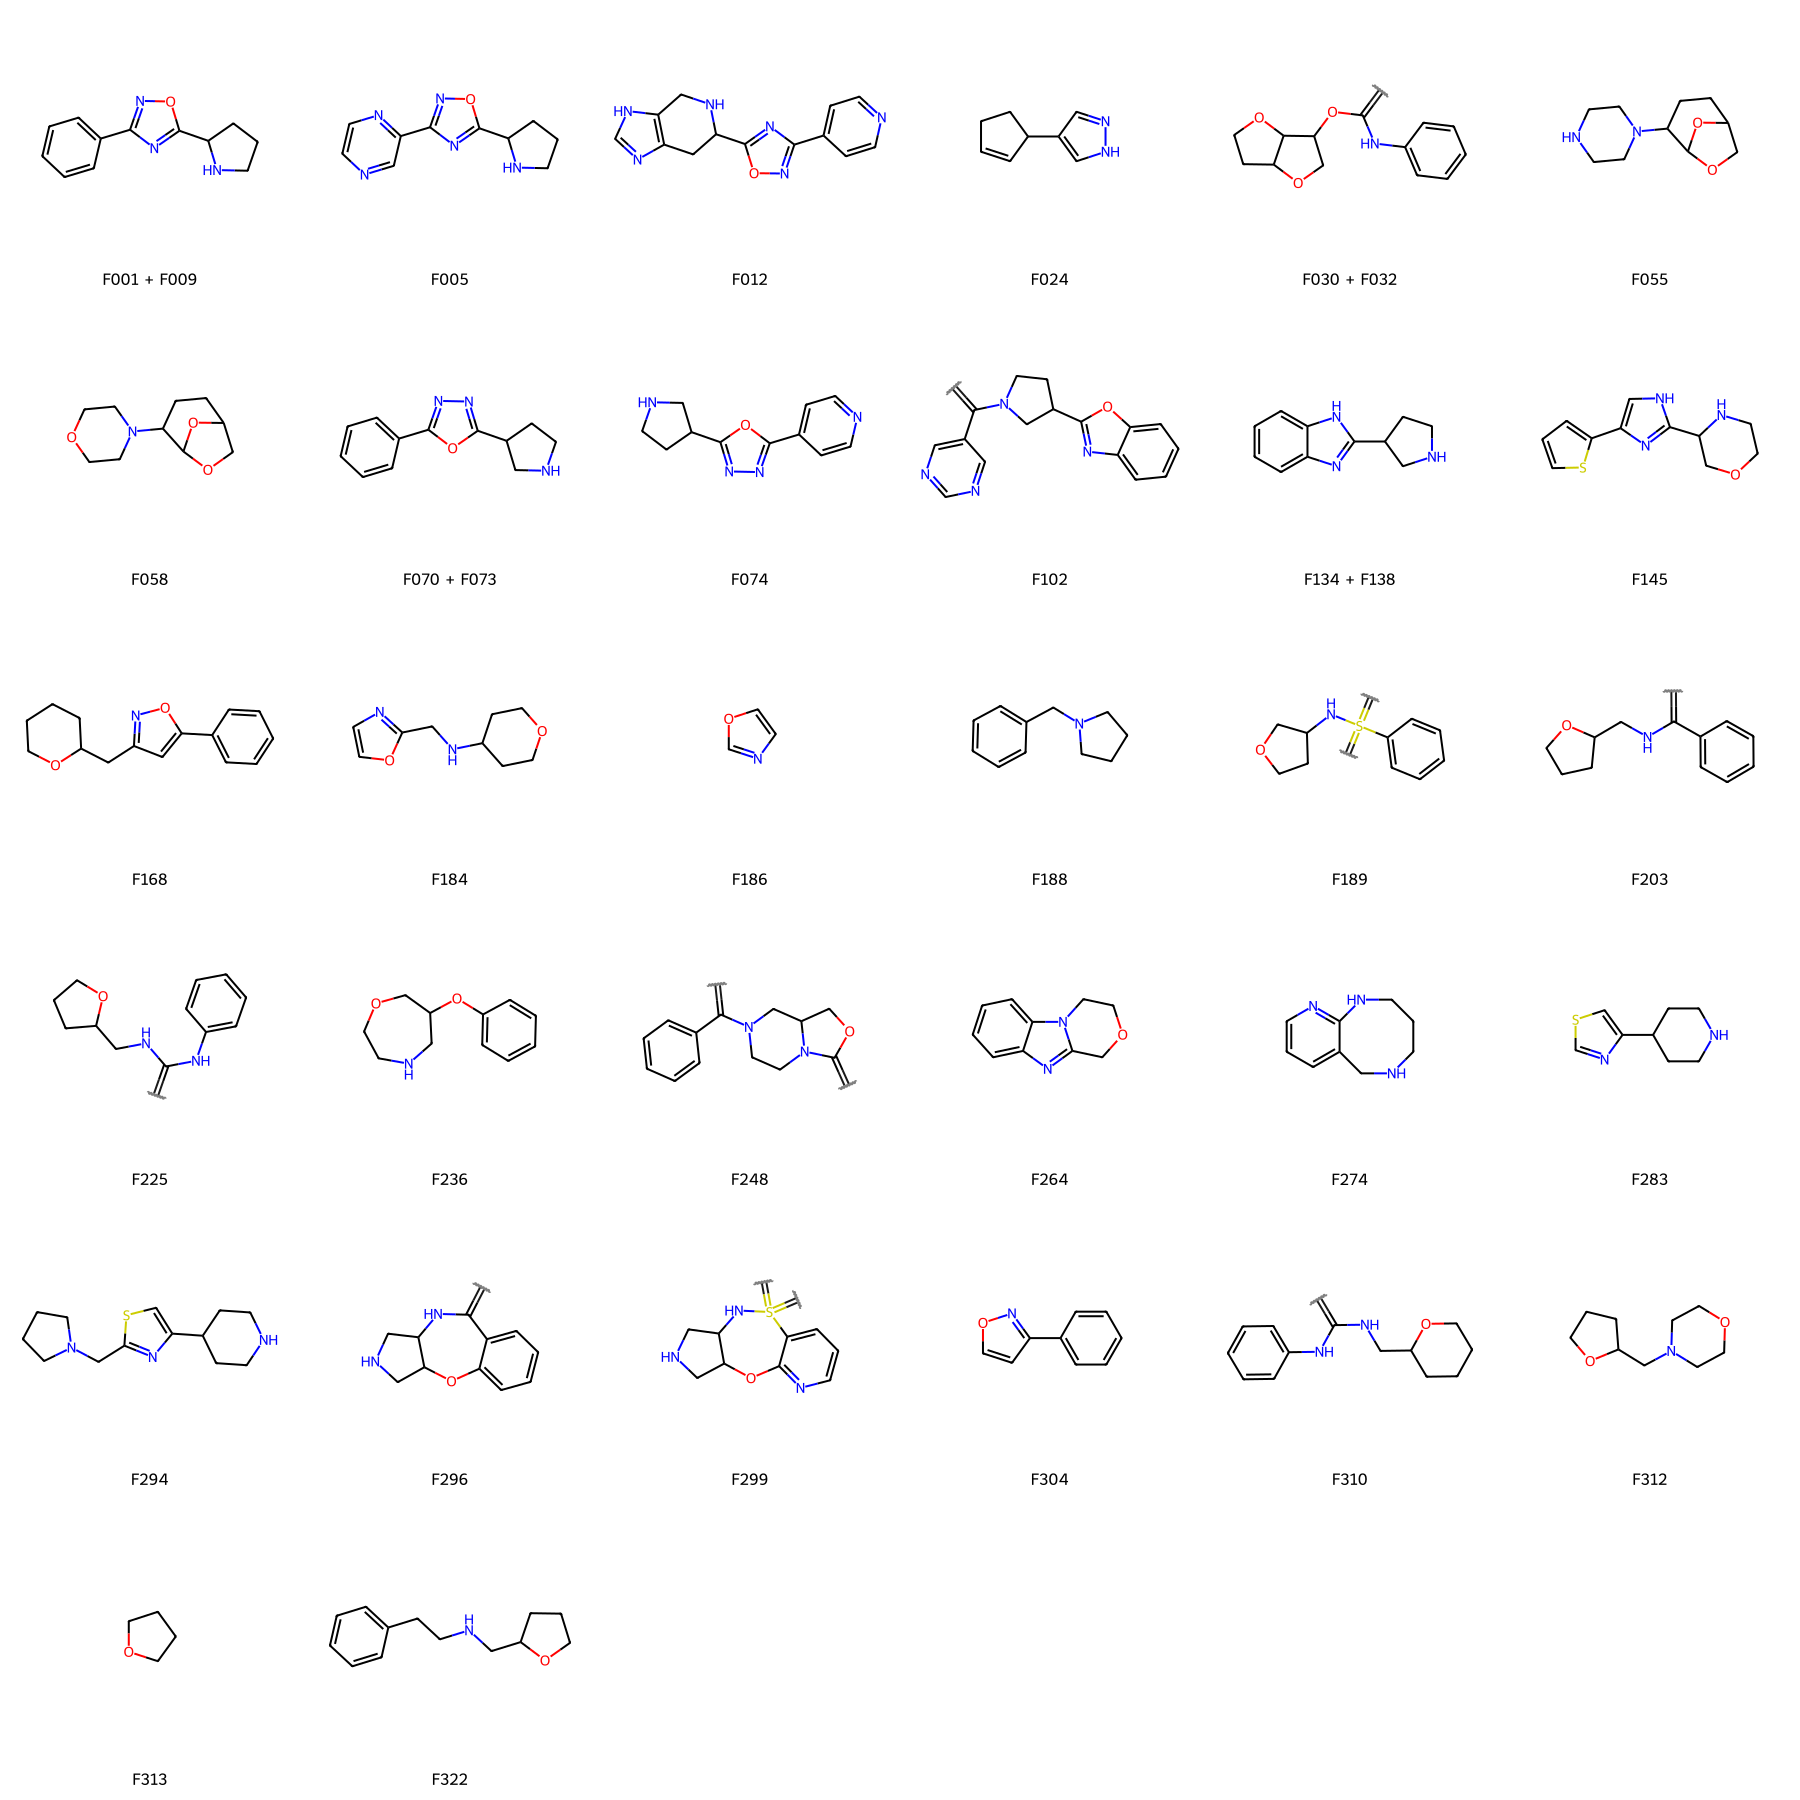

In [14]:
scaffolds_grid, unique_df = identify_unique_scaffolds(df = CF_scaffold_df, 
                                                     reference_df = databases_scaffold_df, 
                                                     variant = 'True_BM', 
                                                     parameters=default_parameters,
                                                     filename=os.path.join(filepath, 'CF_Scaffolds_Unique_TrueBM.png')
                                                     )

scaffolds_grid

2 unique True_CSK scaffolds.


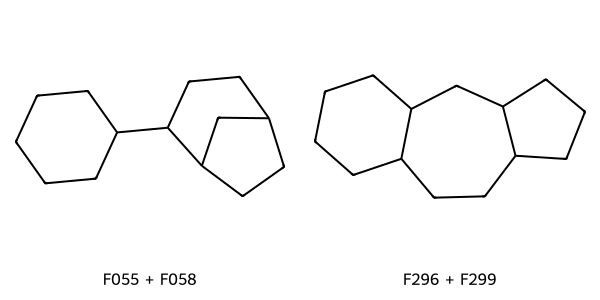

In [15]:
scaffolds_grid, unique_df = identify_unique_scaffolds(df = CF_scaffold_df, 
                                                     reference_df = databases_scaffold_df, 
                                                     variant = 'True_CSK', 
                                                     # Use the default parameters, but temporarily adjust the molsPerRow parameter 
                                                     parameters = {**default_parameters, 'molsPerRow': 2},
                                                     filename=os.path.join(filepath, 'CF_Scaffolds_Unique_TrueCSK.png')
                                                     )

scaffolds_grid

## Compared to the PKA-specific reference datasets

In [16]:
# Create a subdataset for all molecules in the ChEMBL_PKA and the PDB databases
PKA_scaffold_df = scaffold_df.loc[scaffold_df['Dataset'].isin(['ChEMBL_PKA', 'PDB'])]
PKA_scaffold_df = PKA_scaffold_df.reset_index(drop=True)

# Initialize a dictionary
unique_CF_PKA = {}

# Loop over the SMILES columns (of the Bemis-Murcko Variants)
for col in BM_scaffold_SMILES_cols:
    # To compare the subdataset of the CrystalsFirst molecule with the dataset for all other database 
    # Use the SMILES column of these subdatasets, convert to sets and find the difference, and convert result to list
    unique_CF_PKA[col] = list(set(CF_scaffold_df[col].to_list()) - set(PKA_scaffold_df[col].to_list()))
    print(f"{len(unique_CF_PKA[col])} unique {col.replace('_SMILES', '')} scaffolds.")

32 unique True_BM scaffolds.
32 unique Bajorath_BM scaffolds.
32 unique RDKit_BM scaffolds.
18 unique RDKit_Generic scaffolds.
13 unique True_CSK scaffolds.


13 unique True_CSK scaffolds.
For comparison, the default legend would be = 
 ['F001 + F005 + F009 + F070 + F073 + F074 + F145', 'F030 + F032', 'F055 + F058', 'F102', 'F168', 'F225 + F322', 'F236', 'F248', 'F264', 'F274', 'F294', 'F296 + F299', 'F310']


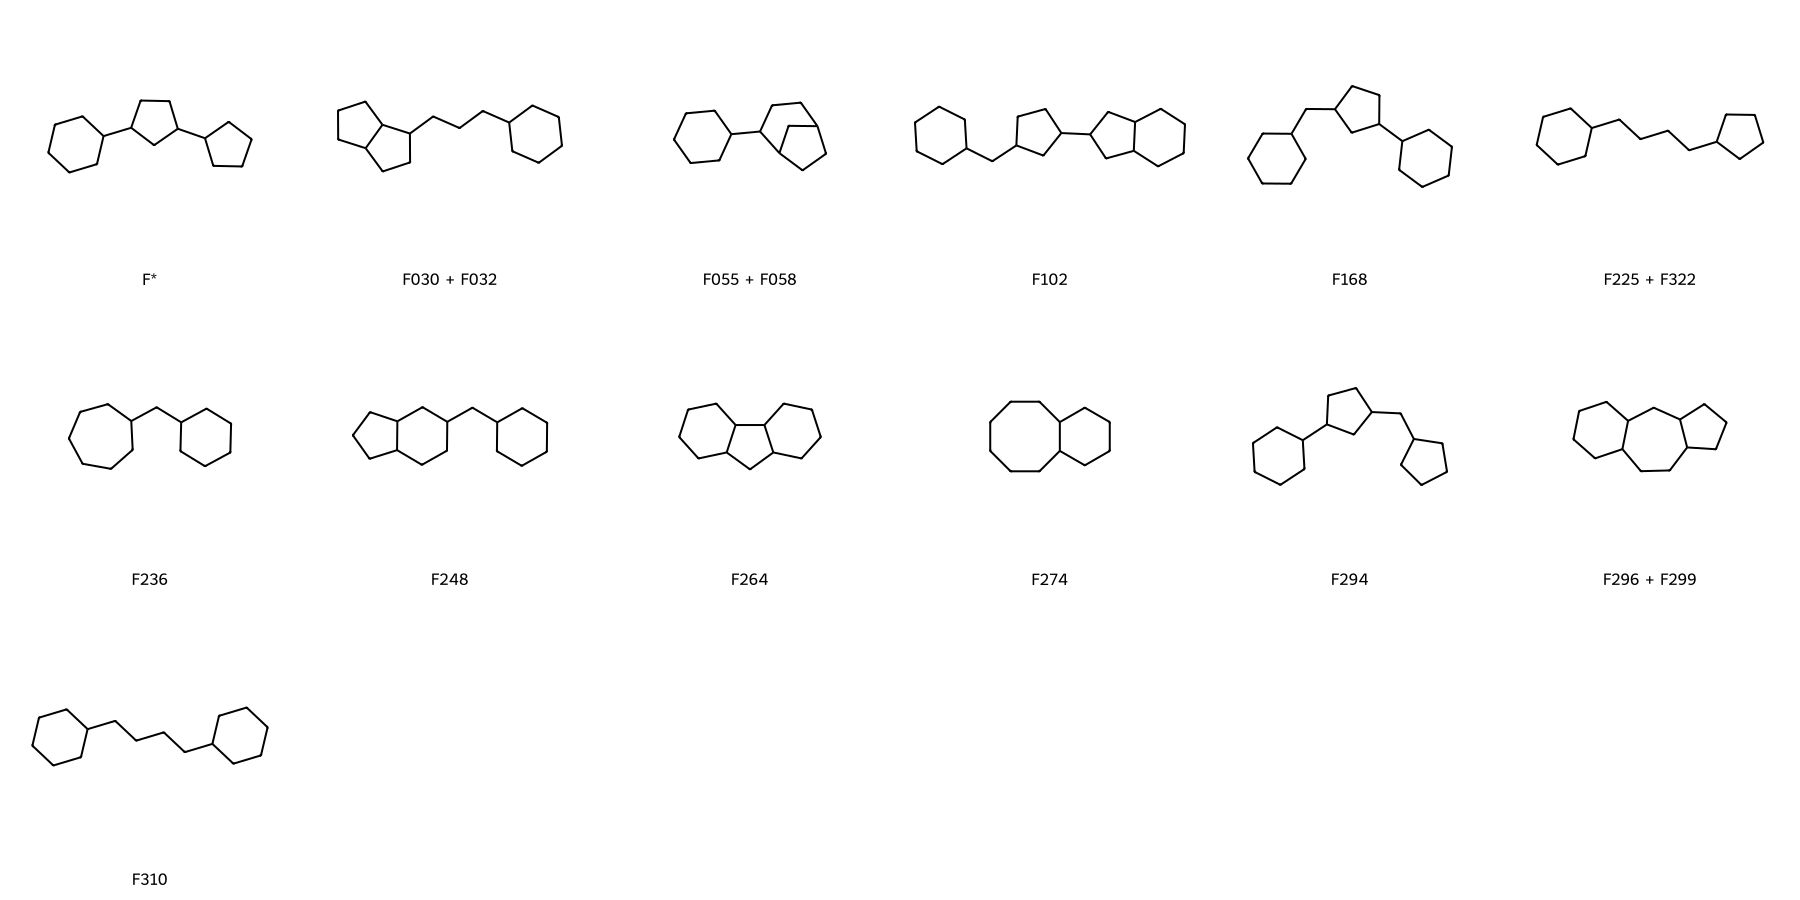

In [17]:
custom_legend = ['F*', 'F030 + F032', 'F055 + F058', 'F102', 'F168', 'F225 + F322', 
                 'F236', 'F248', 'F264', 'F274', 'F294', 'F296 + F299', 
                 'F310']

scaffolds_grid, unique_df = identify_unique_scaffolds(df = CF_scaffold_df, 
                                                     reference_df = PKA_scaffold_df, 
                                                     variant = 'True_CSK', 
                                                     # Use the default parameters, but temporarily add the legends parameter
                                                     parameters = {**default_parameters, 'legends': custom_legend},   
                                                     filename= os.path.join(filepath, 'CF_Scaffolds_UniquePKA_TrueCSK.png')
)

scaffolds_grid

## Compared to the PDB reference dataset only

In [18]:
# Create a subdataset for all molecules, except the CrystalsFirst ones
PDB_scaffold_df = scaffold_df.loc[scaffold_df['Dataset'].isin(['PDB'])]
PDB_scaffold_df = PDB_scaffold_df.reset_index(drop=True)

# Initialize a dictionary
unique_CF_PDB = {}

# Loop over the SMILES columns (of the Bemis-Murcko Variants)
for col in BM_scaffold_SMILES_cols:
    # To compare the subdataset of the CrystalsFirst molecule with the dataset for all other database 
    # Use the SMILES column of these subdatasets, convert to sets and find the difference, and convert result to list
    unique_CF_PDB[col] = list(set(CF_scaffold_df[col].to_list()) - set(PDB_scaffold_df[col].to_list()))
    print(f"{len(unique_CF_PDB[col])} unique {col.replace('_SMILES', '')} scaffolds.")

32 unique True_BM scaffolds.
32 unique Bajorath_BM scaffolds.
32 unique RDKit_BM scaffolds.
18 unique RDKit_Generic scaffolds.
13 unique True_CSK scaffolds.


In [19]:
# scaffolds_grid, unique_df = identify_unique_scaffolds(df = CF_scaffold_df, 
#                                                      reference_df = PDB_scaffold_df, 
#                                                      variant = 'True_CSK', 
#                                                      parameters=default_parameters, 
#                                                      filename=None)

# scaffolds_grid